**Question: Are there differences in environmental exposure among patients with early-onset vs late-onset Asthma?**
* Find patients diagnosed with Asthma
* Find age of diagnosis for Asthma patients
* Find location for Asthma patients
* Find exposures by location for Asthma patients
* Compare exposures of patients diagnosed with Asthma during childhood vs during adulthood

**Data Sources**
* HUSH+ synthetic data resource
* [FHIR synthetic data resource](http://ictrweb.johnshopkins.edu/ictr/synthetic/)
* [UMLS](https://www.nlm.nih.gov/research/umls/), NOTE: there is a Web API [here](https://documentation.uts.nlm.nih.gov/rest/home.html) 
* [OHDSI Web API](http://www.ohdsi.org/web/wiki/doku.php?id=documentation:software:webapi)
* [Open AQ Platform API](https://docs.openaq.org), An API for open air quality data (pm25)
* [Green Translator Exposures API](https://exposures.renci.org/v1/ui), An API for pm25 and o3 measures

### Function and dataset definitions

In [1]:
## All the imports we need
import urllib2
from urllib2 import Request, urlopen, URLError
from urllib import quote_plus

import mysql.connector

import pprint, json, requests

from datetime import datetime, timedelta
from dateutil.parser import parse as parse_date
from greentranslator.api import GreenTranslator
query = GreenTranslator ().get_query ()

import dateutil

import zipcode

import string

%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
#connect to UMLS
try:
    cnx = mysql.connector.connect(user='tadmin',
                                password='ncats_translator!',
                                database='umls',
                                host='translator.ceyknq0yekb3.us-east-1.rds.amazonaws.com')
except mysql.connector.Error as err:
    if err.errno == errorcode.ER_ACCESS_DENIED_ERROR:
        print("Something is wrong with your user name or password")
    elif err.errno == errorcode.ER_BAD_DB_ERROR:
        print("Database does not exist")
    else:
        print(err)
else:
    print
    #cnx.close()

#### UMLS and OHDSI functions

In [3]:
## Given disease/condition term, get back ICD codes from OHDSI
def findICD_ohdsi(txt, icd_version = 9):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")    
    url_con = "http://api.ohdsi.org/WebAPI/vocabulary/search"
    headers = {'content-type': 'application/json'}
    params = {"QUERY": txt,
              "VOCABULARY_ID": [icd_type]}
    response = requests.post(url_con, data=json.dumps(params), headers=headers)
    data= json.loads(response.text.decode('utf-8'))
    return [d["CONCEPT_CODE"] for d in data]
print findICD_ohdsi('asthma')

# Get ICD10/ICD9 code for a given string from UMLS. By default we get back ICD10.
def findICD_umls(name, icd_version = 10):
    if icd_version == 9:
        icd_type = 'ICD9CM'
    elif icd_version == 10:
        icd_type = 'ICD10'
    else: raise Exception("Invalid ICD version specified")

    cursor = cnx.cursor()
    query = ("SELECT CUI FROM umls.MRCONSO WHERE STR='"+name+"'")
    cursor.execute(query, ())
    res = "Undef"
    for code in cursor:
        if res=="Undef":
            res = code
    if res != "Undef":
        query = ("SELECT CODE FROM umls.MRCONSO WHERE SAB='"+icd_type+"' AND CUI='"+res[0]+"'")
        cursor.execute(query, ())
        icd10 = []
        for code in cursor:
            icd10.append(code[0])
        return (icd10)
    return ("Undef")
print findICD_umls("asthma")

[u'E945.7', u'493', u'493.9', u'493.90', u'493.92', u'493.91', u'493.2', u'493.20', u'493.22', u'493.21', u'493.82', u'493.0', u'493.00', u'493.02', u'493.01', u'V17.5', u'493.1', u'493.10', u'493.12', u'493.11', u'493.8', u'975.7']
[u'J45', u'J45.9']


#### Exposure data source founctions

In [4]:
#Function takes date of diagnosis, and location as input and returns degree of exposure 

def findExposureAtDateOfDx(dxdate,lon,lat):
    #dxnextdate = dateutil.parser.parse(dxdate) + timedelta(days=1)
    #dxnextdate = datetime.date(dxnextdate)
    pm25score = query.expo_get_scores (exposure_type = 'pm25',
                            start_date = dxdate,
                            end_date = dxdate,
                            exposure_point = ''+lon+','+lat+'')
    return(pm25score) 

def findAirQualityAtDateOfDx(dxdate,lat,lon):
    try:
        url = "https://api.openaq.org/v1/measurements?coordinates="+str(lat)+','+str(lon)+"&date="+str(dxdate)+"&parameter=pm25"
        #print url
        txt = urlopen(url).read()
        #print txt
    except Exception, e:
        raise Exception(e)
    exps= json.loads(txt)
    #pprint.pprint(exps)
    return(exps)

#### HUSH+ and FHIR synthetic data source functions

In [5]:
## Functions to retreive patients from different sources - HUSH+ & FHIR synthetic
def findPatients_fhir(code):
    try:
        url ="http://ictrweb.johnshopkins.edu/rest/synthetic/Condition?icd_10="+code+"&_count=999"
        txt = urlopen(url).read()
    except Exception, e:
        raise Exception(e)
    stuff = json.loads(txt)
    #print stuff
    return(stuff)

def findPatients_unc(age='8', sex='male', race='white', location='OUTPATIENT'):
    query = GreenTranslator ().get_query()
    return query.clinical_get_patients(age, sex, race, location)

In [6]:
#Function to retrieve age at diagnosis & location for patients from FHIR synthetic
def findDxAgeLocation_fhir(stuff):
    #pprint.pprint(stuff)
    res = []
    if stuff==[]:
        return []
    for p in stuff['entry']:
        #pprint.pprint(p)
        d1 = p['assertedDate']
        id = p['subject']['reference'][8:]
        try:
            url = 'http://ictrweb.johnshopkins.edu/rest/synthetic/Patient/'+id
            txt = urlopen(url).read()
        except:
            print "ictr api doesn't work"
        st = json.loads(txt)
        #pprint.pprint(st)
        d2 = st['birthDate']
        z = st['address'][0]['postalCode']
        datedx = d2 #e.g. 1925-12-08 00:00:00
        d1 = dateutil.parser.parse(d1)
        d2 = dateutil.parser.parse(d2)
        #print d1
        #print d2
        diff = d1 - d2
        #print diff
             
        obj = zipcode.isequal(z.encode("ascii", "ignore"))
        if obj is not None:
            d = obj.to_dict()
            lat = d['lat']
            lon = d['lon']
        else:
            lat = None
            lon = None
        t = (id,diff.days,datedx,lat,lon)         
        res.append(t)
    return(res)

#Add function to retrieve age at diagnosis & location for patients from HUSH+

### "What is the age range of Asthma diagnoses, grouped by location?"

count      806.000000
mean      8254.647643
std       6054.258947
min        151.000000
25%       3566.500000
50%       6988.500000
75%      11537.000000
max      31215.000000
Name: ageOfDxInDays, dtype: float64


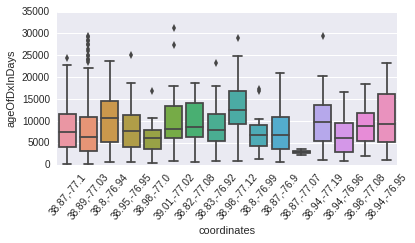

In [17]:
asthmaCodes = findICD_umls("asthma") # We go with ICD10 codes

## Get age of diagnosis & locations for FHIR synthetic patients.
p_agelocs = []

#print "Codes"
#print len(asthmaCodes)
#print asthmaCodes
p = []

for icd in asthmaCodes:
    try:
        pp = findPatients_fhir(icd)
        #print pp
        if len(pp)>0:
            #print "HERE"
            p = pp
        # patients with icd exist
    except:
        print "no patients with icd"
        exit()

#print "Patients"
#pprint.pprint(p)

p_ageloc = findDxAgeLocation_fhir(p)
#pprint.pprint(p_ageloc)
    
for dx in p_ageloc:
    num = int(dx[0])
    ageOfDxInDays = int(dx[1])
    dateAtDx = str(dx[2])
    lat = dx[3]
    lon = dx[4]
    coordinates=''+str(lat)+','+str(lon)+''
    #print coordinates
    p_agelocs.append((num, ageOfDxInDays,dateAtDx,lat,lon,coordinates))
    #p_agelocs.append(dx)
#print p_agelocs[1]
p_agelocs_df = pd.DataFrame(p_agelocs, columns=['id', 'ageOfDxInDays', 'dateAtDx', 'lat', 'lon','coordinates'])
#print  p_agelocs_df
    
s = p_agelocs_df['ageOfDxInDays']
print s.describe()
    
g = sns.factorplot(x="coordinates", y="ageOfDxInDays", data=p_agelocs_df, kind="box", size=3, aspect=2)
g.set_xticklabels(rotation=50)


## Add code to get age of diagnosis & locations for HUSH+ patients.

### "What is the age range of Asthma diagnoses, grouped by air quality threshold?"
NOTE: will need to find literature-based thresholds for high & low air quality

In [21]:
##For date of diagnosis and location, what is air quality (pm25)?

#findExposureAtDateOfDx("2010-01-07","35.9131996","-79.0558445")
#findAirQualityAtDateOfDx("2010-01-07","35.91","-79.05")

pprint.pprint(p_agelocs)
pprint.pprint(p_agelocs_df)

print "##### CSV CUT HERE #####"
for item, p in p_agelocs_df.iterrows():
    #print "item, p"
    
    # ****** UNCOMMENT THIS LINE TO GENERATE CSV ENTITIES ******
    # You will need to comment this line and rerun this sectioh to save changes.  Otherwise, you will
    # get an 'entity too large' error
    #print str(p['id'])+","+str(p['ageOfDxInDays'])+",\""+str(p['dateAtDx'])+"\","+str(p['lat'])+","+str(p['lon'])
    #print item
    #print p
    dateDx = p['dateAtDx']
    lat = p['lat']
    lon = p['lon']
    #print dateDx
    #print lat
    txt =''
    try:
        txt = findAirQualityAtDateOfDx(dateDx,lat,lon)
        #findExposureAtDateOfDx(dateDx,lon,lat)
    except:
        print "location not found"
        exit()
    if len(txt)> 0:
        try:
            p_exp = json.loads(txt)
        except:
            p_exp = []
    else:
        p_exp = []
    print p_exp
    #print p_exp
    try:
        pm25 = p_exp['value']
    except:
        pm25 = "Unknown"
    # ****** UNCOMMENT THIS LINE TO GENERATE CSV ENTITIES ******
    # You will need to comment this line and rerun this sectioh to save changes.  Otherwise, you will
    # get an 'entity too large' error
    print str(p['id'])+","+str(p['ageOfDxInDays'])+",\""+str(p['dateAtDx'])+"\","+str(p['lat'])+","+str(p['lon'])+",\""+str(pm25)+"\""

    #print pm25
print "##### CSV CUT HERE #####"



[(894149507, 20509, '1944-04-08', 38.87, -77.1, '38.87,-77.1'),
 (300399621, 13878, '1937-03-13', 38.89, -77.03, '38.89,-77.03'),
 (811254783, 17706, '1949-04-17', 38.8, -76.94, '38.8,-76.94'),
 (225533230, 11267, '1977-11-13', 38.95, -76.95, '38.95,-76.95'),
 (371526625, 3188, '1955-03-25', 38.89, -77.03, '38.89,-77.03'),
 (569883974, 4570, '1988-07-24', 38.98, -77.0, '38.98,-77.0'),
 (909134213, 11811, '1966-02-20', 38.8, -76.94, '38.8,-76.94'),
 (230444650, 24912, '1941-06-27', 38.89, -77.03, '38.89,-77.03'),
 (738765998, 5244, '1992-12-06', 38.8, -76.94, '38.8,-76.94'),
 (447600935, 1409, '1992-05-02', 38.87, -77.1, '38.87,-77.1'),
 (975849373, 10688, '1972-11-01', 38.89, -77.03, '38.89,-77.03'),
 (618976413, 31215, '1918-04-27', 39.01, -77.02, '39.01,-77.02'),
 (858150638, 829, '1968-10-29', 38.89, -77.03, '38.89,-77.03'),
 (485187276, 6143, '1990-06-02', 38.89, -77.03, '38.89,-77.03'),
 (962308461, 712, '1983-10-20', 38.82, -77.08, '38.82,-77.08'),
 (873467592, 6556, '1978-01-13'

 (608423142, 9162, '1982-06-05', 38.95, -76.95, '38.95,-76.95'),
 (818767353, 8714, '1985-05-03', 38.98, -77.08, '38.98,-77.08'),
 (143513878, 21244, '1918-04-23', 38.89, -77.03, '38.89,-77.03'),
 (176175851, 5105, '1997-12-09', 38.95, -76.95, '38.95,-76.95'),
 (706241677, 13665, '1961-06-16', 38.95, -76.95, '38.95,-76.95'),
 (165247550, 7544, '1977-02-25', 38.89, -77.03, '38.89,-77.03'),
 (929599834, 6391, '1985-02-04', 38.89, -77.03, '38.89,-77.03'),
 (656315891, 4330, '1963-03-16', 38.89, -77.03, '38.89,-77.03'),
 (796416246, 18735, '1962-09-05', 38.82, -77.08, '38.82,-77.08'),
 (131716869, 1201, '1991-07-29', 38.89, -77.03, '38.89,-77.03'),
 (809015918, 10913, '1976-06-24', 38.89, -77.03, '38.89,-77.03'),
 (769910732, 6998, '1983-03-21', 38.89, -77.03, '38.89,-77.03'),
 (176627104, 3954, '1961-11-17', 38.89, -77.03, '38.89,-77.03'),
 (237811778, 11574, '1969-08-02', 38.8, -76.94, '38.8,-76.94'),
 (680943325, 22017, '1946-05-30', 38.89, -77.03, '38.89,-77.03'),
 (922610824, 6037, '1

 (872026969, 10329, '1959-01-31', 38.89, -77.03, '38.89,-77.03'),
 (939064684, 13139, '1936-07-14', 38.89, -77.03, '38.89,-77.03'),
 (796533514, 13429, '1967-10-18', 38.89, -77.03, '38.89,-77.03'),
 (654728281, 1277, '2002-11-03', 38.8, -76.99, '38.8,-76.99'),
 (684842562, 10788, '1970-02-25', 38.87, -76.9, '38.87,-76.9'),
 (981846455, 10563, '1951-10-08', 38.95, -76.95, '38.95,-76.95'),
 (363706743, 1436, '2003-01-03', 38.89, -77.03, '38.89,-77.03'),
 (141756688, 16348, '1961-07-13', 38.89, -77.03, '38.89,-77.03'),
 (357862934, 18445, '1955-02-10', 38.82, -77.08, '38.82,-77.08'),
 (434889442, 9313, '1988-03-30', 38.89, -77.03, '38.89,-77.03'),
 (331277554, 3677, '1931-10-14', 38.98, -77.08, '38.98,-77.08'),
 (898057510, 7959, '1981-04-24', 38.89, -77.03, '38.89,-77.03'),
 (241403300, 11122, '1950-03-11', 38.98, -77.08, '38.98,-77.08'),
 (391675822, 1876, '1965-12-22', 38.87, -77.1, '38.87,-77.1'),
 (875121040, 2403, '1997-05-26', 38.89, -77.03, '38.89,-77.03'),
 (251711798, 7716, '198

300399621,13878,"1937-03-13",38.89,-77.03,"Unknown"
811254783,17706,"1949-04-17",38.8,-76.94,"Unknown"
225533230,11267,"1977-11-13",38.95,-76.95,"Unknown"
371526625,3188,"1955-03-25",38.89,-77.03,"Unknown"
569883974,4570,"1988-07-24",38.98,-77.0,"Unknown"
909134213,11811,"1966-02-20",38.8,-76.94,"Unknown"
230444650,24912,"1941-06-27",38.89,-77.03,"Unknown"
738765998,5244,"1992-12-06",38.8,-76.94,"Unknown"
447600935,1409,"1992-05-02",38.87,-77.1,"Unknown"
975849373,10688,"1972-11-01",38.89,-77.03,"Unknown"
618976413,31215,"1918-04-27",39.01,-77.02,"Unknown"
858150638,829,"1968-10-29",38.89,-77.03,"Unknown"
485187276,6143,"1990-06-02",38.89,-77.03,"Unknown"
962308461,712,"1983-10-20",38.82,-77.08,"Unknown"
873467592,6556,"1978-01-13",38.89,-77.03,"Unknown"
514335399,5936,"1997-07-20",38.89,-77.03,"Unknown"
528577910,4479,"1973-12-24",38.89,-77.03,"Unknown"
687675856,12332,"1974-10-12",38.89,-77.03,"Unknown"
722008914,17190,"1960-11-28",38.89,-77.03,"Unknown"
823401928,3543,"1965-05-31",3

817588813,9833,"1988-05-07",38.83,-76.92,"Unknown"
940690009,4922,"1998-03-01",38.94,-77.19,"Unknown"
147504950,3230,"2005-08-01",38.98,-77.0,"Unknown"
768208982,4380,"1983-06-27",38.87,-76.9,"Unknown"
228182163,1377,"1988-11-08",38.89,-77.03,"Unknown"
798442558,9611,"1986-12-13",38.89,-77.03,"Unknown"
663523469,3553,"1982-01-04",38.89,-77.03,"Unknown"
220178839,2287,"1955-07-21",38.89,-77.03,"Unknown"
193904770,29499,"1925-03-27",38.94,-77.19,"Unknown"
927395491,9905,"1973-01-24",38.89,-77.03,"Unknown"
231761782,10677,"1981-12-10",38.89,-77.03,"Unknown"
772243798,14870,"1954-07-06",38.87,-76.9,"Unknown"
281594447,1891,"1995-07-22",38.89,-77.03,"Unknown"
167875220,2533,"2006-10-31",38.87,-76.9,"Unknown"
480264732,27288,"1928-02-18",39.01,-77.02,"Unknown"
641001166,1358,"1984-01-23",38.89,-77.03,"Unknown"
879945683,4264,"1968-12-25",38.95,-76.95,"Unknown"
331927379,2891,"1986-12-02",38.89,-77.03,"Unknown"
849702019,6148,"1970-02-13",38.89,-77.03,"Unknown"
925262953,10082,"1968-09-06",38

948408986,3973,"1995-01-27",38.89,-77.03,"Unknown"
803338354,568,"1991-11-14",38.89,-77.03,"Unknown"
439950147,20980,"1957-09-10",38.89,-77.03,"Unknown"
575332489,14304,"1977-07-15",38.89,-77.03,"Unknown"
983497838,3272,"1995-10-02",38.89,-77.03,"Unknown"
714607883,4446,"1990-12-18",38.95,-76.95,"Unknown"
449812080,2517,"1979-08-20",39.01,-77.02,"Unknown"
459010311,11254,"1982-02-07",38.89,-77.03,"Unknown"
980797042,4085,"2002-12-30",38.89,-77.03,"Unknown"
395731954,5768,"1957-01-19",38.95,-76.95,"Unknown"
773183620,21689,"1949-01-21",38.89,-77.03,"Unknown"
770375887,4602,"1992-04-24",38.89,-77.03,"Unknown"
722382993,6774,"1981-02-26",38.89,-77.03,"Unknown"
445086582,11057,"1980-06-19",38.95,-76.95,"Unknown"
288714129,3779,"1973-11-05",38.87,-77.1,"Unknown"
616022443,1238,"1990-10-01",38.89,-77.03,"Unknown"
350610149,9998,"1957-12-02",38.98,-77.08,"Unknown"
609393014,4579,"1993-07-10",38.89,-77.03,"Unknown"
621360580,3610,"1992-10-29",38.89,-77.03,"Unknown"
710534916,23921,"1946-03-26"

392782286,18653,"1936-12-20",38.89,-77.03,"Unknown"
284843040,14453,"1936-08-15",38.8,-76.94,"Unknown"
336701514,5618,"1953-04-08",38.8,-76.94,"Unknown"
537191851,528,"1979-05-17",38.87,-76.9,"Unknown"
659955891,5310,"1991-05-26",38.89,-77.03,"Unknown"
861505131,2522,"1994-07-30",38.89,-77.03,"Unknown"
632149412,10147,"1976-03-31",38.87,-76.9,"Unknown"
315694294,21650,"1925-12-08",38.89,-77.03,"Unknown"
813054532,2973,"1951-07-30",38.89,-77.03,"Unknown"
234819727,1155,"2007-01-04",38.94,-77.19,"Unknown"
234344293,1709,"1993-03-26",38.89,-77.03,"Unknown"
542294762,6214,"1953-08-30",38.87,-77.1,"Unknown"
538214696,3846,"1951-05-03",39.01,-77.02,"Unknown"
892958248,13502,"1944-09-18",38.95,-76.95,"Unknown"
521324257,1271,"1991-09-01",38.95,-76.95,"Unknown"
649952557,2617,"1976-02-02",38.89,-77.03,"Unknown"
649318651,8756,"1953-12-02",38.94,-77.19,"Unknown"
845727180,2881,"1973-12-24",38.83,-76.92,"Unknown"
593952978,16732,"1950-09-16",38.98,-77.0,"Unknown"
722580265,9973,"1977-11-25",38.8

286535858,12135,"1981-07-12",38.89,-77.03,"Unknown"
816342099,11338,"1978-06-23",38.89,-77.03,"Unknown"
489618920,4788,"1983-12-11",38.98,-77.0,"Unknown"
412676963,7904,"1977-05-25",38.89,-77.03,"Unknown"
763959173,13594,"1971-12-24",38.95,-76.95,"Unknown"
919629696,1039,"1947-11-03",38.95,-76.95,"Unknown"
552110544,7156,"1967-06-13",38.8,-76.99,"Unknown"
303886061,5507,"1990-12-24",38.95,-76.95,"Unknown"
756615731,2380,"1951-09-19",38.89,-77.03,"Unknown"
834485602,11002,"1946-07-10",38.89,-77.03,"Unknown"
901007880,14718,"1967-08-02",38.89,-77.03,"Unknown"
654674639,12442,"1959-11-19",38.89,-77.03,"Unknown"
746202841,18250,"1940-05-02",38.98,-77.12,"Unknown"
951930416,3070,"1982-09-26",38.89,-77.03,"Unknown"
811226408,3945,"1991-11-23",38.87,-77.1,"Unknown"
879879708,14064,"1946-09-29",38.89,-77.03,"Unknown"
613803323,13748,"1964-12-12",38.94,-77.19,"Unknown"
888034824,11754,"1968-04-23",39.01,-77.02,"Unknown"
643510340,6385,"1955-05-22",38.89,-77.03,"Unknown"
739265286,4692,"1979-06-